In [32]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import gmean
import matplotlib.ticker as mtick
import matplotlib.dates as dates

In [33]:
d = pd.concat([
    pd.read_csv(f"measurements/{n}.csv",
                names=["name", "actual", "expected", "duration", "browser", "subscript"])
    for n in [1, 5, 10, 50, 100, 500]])
d

,name,actual,expected,duration,browser,subscript
0,angular-dart,passed,failed,13.529671,firefox,1
1,angular-dart,passed,failed,13.033739,firefox,1
2,angular-dart,passed,failed,13.221069,firefox,1
3,angular-dart,passed,failed,13.623472,firefox,1
4,angular-dart,passed,failed,13.258372,firefox,1
...,...,...,...,...,...,...
425,vue,passed,passed,156.638816,firefox,500
426,vue,passed,passed,185.691179,firefox,500
427,vue,passed,passed,178.570207,firefox,500
428,vue,passed,passed,171.199023,firefox,500


In [34]:
expected_failed = d[d["expected"] == "failed"]
false_positives = expected_failed[expected_failed["actual"] == "passed"]

false_positive_rates = pd.DataFrame()
false_positive_rates["rate"] = false_positives.groupby("subscript")["actual"].count() / expected_failed.groupby("subscript")["actual"].count()
false_positive_rates

,rate
subscript,
1,1.000000
5,0.895455
10,0.645455
50,0.304545
100,0.213636
500,0.081818


In [35]:
errors = d[d["actual"] == "error"]
error_rates = pd.DataFrame()
errors.groupby(["subscript", "name"]).agg(errors=('actual', 'count'))

errors
subscript name                
50        angular-dart       1
          reagent            1
100       reagent            1
500       angular-dart       1
          elm                2
          reagent            3

In [36]:
expected_passed = d[d["expected"] == "passed"]

x = pd.DataFrame()
x["gmean"] = expected_passed.groupby("subscript")["duration"].apply(gmean)
x["stddev"] = expected_passed.groupby("subscript")["duration"].std()
x

,gmean,stddev
subscript,,
1,12.841619,0.443562
5,13.220053,0.538000
10,14.396001,1.033888
50,26.395305,3.866946
100,40.994505,7.442214
500,149.133493,43.553283


In [37]:
x["rate"] = false_positive_rates["rate"]
x.to_csv("results.csv")
x

,gmean,stddev,rate
subscript,,,
1,12.841619,0.443562,1.000000
5,13.220053,0.538000,0.895455
10,14.396001,1.033888,0.645455
50,26.395305,3.866946,0.304545
100,40.994505,7.442214,0.213636
500,149.133493,43.553283,0.081818


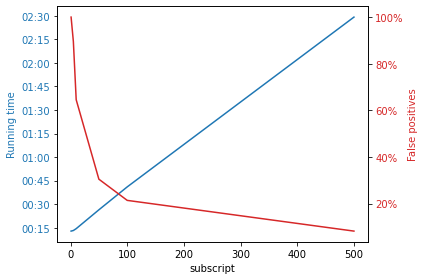

In [38]:

def format_duration(x, pos):
    hours = int(x//3600)
    minutes = int((x%3600)//60)
    seconds = int(x%60)
    return "{:02d}:{:02d}".format(minutes, seconds)

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Subscript')
ax1.set_ylabel('Running time', color=color)
x.gmean.plot(ax=ax1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax1.yaxis.set_major_locator(mtick.MultipleLocator(base=15))
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(format_duration))

ax2 = ax1.twinx()

ax2.xaxis.set_major_locator(mtick.MultipleLocator(base=100))
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

color = 'tab:red'
ax2.set_ylabel('False positives', color=color)
x.rate.plot(ax=ax2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 

fig.savefig("plot.ps")